In [1]:
import numpy as np
import pandas as pd
import requests
import urllib.request
import matplotlib.pyplot as plt
import time
from jyquickhelper import add_notebook_menu
from sklearn import preprocessing
from collections import namedtuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


In [2]:
add_notebook_menu()

## Data generation
We first generate very simple data, in order to tune our algorithms and understand their behaviour in a controlled environment.

In [3]:
np.random.seed(100)
n_samples, n_features = 10000, 50
X = np.random.randn(n_samples, n_features)
W_real = np.random.randn(n_features)
Y = np.sign(X.dot(W_real) + np.random.randn(n_samples))

## Preprocessing the data

#### Normalization
SVM tries to maximize the distance between the separating plane and the support vectors. If one feature (i.e. one dimension in this space) has very large values, it will dominate the other features when calculating the distance. If you rescale all features (e.g. to [0, 1]), they all have the same influence on the distance metric.

In [4]:
X_scale= preprocessing.scale(X)
pd.DataFrame(X_scale).describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,...,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-2.825518e-17,8.480994e-17,-1.912689e-17,4.664411e-17,-5.488943e-17,-4.496403e-18,-5.209166e-17,-4.857226e-17,-2.835510e-17,-1.848799e-17,...,-2.769451e-17,-1.754152e-18,-6.265544e-17,4.611866e-17,1.023626e-17,-1.931788e-18,-1.725509e-16,-3.919087e-17,-1.498801e-18,-6.084022e-18
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,...,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-3.528775e+00,-4.241572e+00,-3.748656e+00,-4.807973e+00,-3.447402e+00,-3.845229e+00,-3.653616e+00,-3.475923e+00,-4.263492e+00,-3.993324e+00,...,-4.266787e+00,-3.819606e+00,-3.923899e+00,-3.581164e+00,-3.929283e+00,-4.226381e+00,-4.036770e+00,-3.505275e+00,-3.637163e+00,-4.210649e+00
25%,-6.694925e-01,-6.761657e-01,-6.799790e-01,-6.638791e-01,-6.786848e-01,-6.792431e-01,-6.851165e-01,-6.739504e-01,-6.787010e-01,-6.667995e-01,...,-6.673000e-01,-6.579927e-01,-6.809715e-01,-6.801206e-01,-6.854098e-01,-6.696009e-01,-6.780757e-01,-6.773196e-01,-6.724490e-01,-6.726675e-01
50%,7.968174e-03,-8.385514e-04,-2.149095e-03,-5.008627e-03,5.223925e-03,1.715171e-03,-7.037973e-03,-5.071468e-03,8.124270e-04,-1.792881e-03,...,-2.617707e-03,6.542836e-04,1.019184e-02,-5.271617e-03,-2.715387e-03,3.938627e-03,-4.482148e-03,1.307084e-02,4.099296e-03,8.299609e-03
75%,6.782644e-01,6.710383e-01,6.805330e-01,6.684502e-01,6.774109e-01,6.789516e-01,6.803765e-01,6.760663e-01,6.760136e-01,6.761831e-01,...,6.729562e-01,6.815861e-01,6.919423e-01,6.898613e-01,6.704945e-01,6.704980e-01,6.820260e-01,6.831873e-01,6.807125e-01,6.793582e-01
max,3.400545e+00,3.536183e+00,3.505806e+00,3.751706e+00,3.557642e+00,3.620859e+00,4.055220e+00,3.606643e+00,3.727794e+00,3.899649e+00,...,3.703564e+00,3.461707e+00,3.804062e+00,3.927934e+00,3.806133e+00,3.591497e+00,3.757283e+00,4.401787e+00,3.924877e+00,3.683498e+00


## Hinge function toolbox

In [5]:
def hinge_loss(X,y,W):
    """
    Compute hinge loss for one observation
    
    Inputs:
        W: primal weights (n_features)
        X: covariates (size n_features)
        y: label (size 1)
        
    Output:
        hinge loss at observation (size 1)
    """
    prod= np.dot(X, W)
    return np.maximum(0, 1- y*prod)

def hinge_dual(u, y):
    """
    Compute hinge dual for one observation
    
    Inputs:
        Y: label (size 1)
        u: prediction (size 1)
        
    Outputs:
        dual for a given observation (size 1)
    """
    prod = u * y
    prod[prod > 0] = np.inf
    prod[prod < -1] = np.inf
    return prod

def cum_loss_primal(W, X, Y, lamb):
    '''
    Compute primal suboptimality of the model for the hinge function
    
    Inputs:
        W: primal weights (n_features)
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        loss_funct: loss function to consider (default: hinge_loss)
    
    Outputs:
        primal (size 1)
    '''
    penal= (lamb/2)*np.linalg.norm(W, ord=2)
    loss = np.mean(hinge_loss(X,Y,W))
    return penal + loss

def cum_loss_dual(alpha, X, Y, lamb):
    """
    Compute dual suboptimality of the model for the hinge function 
    
    Inputs:
        alpha: dual weights (n_samples)
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        lamb: regularization (size 1)

    Outputs:
        cumulative primal loss (size 1)
    """   
    W = w_from_alpha(alpha, X, lamb)
    cumloss = np.mean(- hinge_dual(- alpha, Y))
    penal = -(lamb / 2) * np.power(np.linalg.norm(W), 2)
    return cumloss + penal


## Pegasos algorithm

### Setting first hyperparameters

In [20]:
n_epoch = 5
n_iter = n_epoch*n_samples # for comparison purposes
lamb=0.01

### Basic implementation of Pegasos
We want to show first here the behaviour of the basic implementation of Pegasos as described by Shalev-Shwartz et al. (2007). Additionally, the PEGASOS projection step is skipped, as it
can be shown that even without it, $||w||^2 \leq 4/\lambda$ is maintained.

In [21]:
def pegasos_basic(X,Y,lamb, n_iter):
    """
    Implement Pegasos in its basic definition
    In Shalev-Shwartz, Shai, et al. "Pegasos: Primal estimated sub-gradient solver for svm." 
    Mathematical programming 127.1 (2011): 3-30.
    
    Inputs:
        X: covariates matrix (n_samples,n_features) 
        Y: labels vector, coded as (-1,1), (n_samples)
        lamb: regularization paramater
        n_iter: number of iterations
    
    Outputs:
        primal_: primal suboptimality at each iteration (n_iter)
        rtime: running time for each iteration (n_iter)
        w: final weights (n_features)
    
    """
    m = len(Y) #number of observations
    rtime = [] #keeping track of running time
    
    # Initialisation
    w= np.zeros(n_features) 
    primal= []


    for i in range(0,n_iter):

        start_time = time.perf_counter()
        
        t=np.random.randint(m) # draw random index
        eta = 1/(lamb*(i+1)) # define step size
        
        # Compute subgradient
        x, y = X[t], Y[t]
        subgrad= y*(w.dot(x))
        
        # Compute weight
        if subgrad <1:
            w=(1-eta*lamb)*w+ (eta*y)*x
        else :
             w=(1-eta*lamb)*w
                
        # Estimate running time
        rtime.append(time.perf_counter() - start_time)
        
        # To monitor the optimization (excluded from rtime)
        cost = cum_loss_primal(w,X,Y,lamb)
        primal.append(cost)
        
    print("total running time:",sum(rtime), "sec") 
    print("final primal suboptimality:", cost)

    output = namedtuple("output", ["primal", "rtime", "w"])
    out= output(primal, rtime, w)
    return out
    

We run the algorithm on our simulated data

In [22]:
result_peg_basic = pegasos_basic(X_scale,Y,lamb,n_iter)

total running time: 0.8728260793286609 sec
final primal suboptimality: 0.162734265541


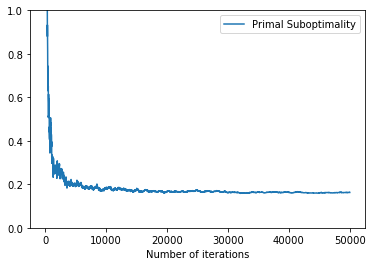

In [23]:
plt.plot(range(0,n_iter),result_peg_basic.primal, label="Primal Suboptimality")
plt.xlabel("Number of iterations")
plt.ylim((0,1))
plt.legend()
plt.show()

### Variant Pegasos
We used a variant of the previous method, with a single example used in each update: Following
[Bottou](http://leon.bottou.org/projects/sgd?s[]=sgd), instead of sampling an example independently
at each iteration, a random permutation over the training set
is used. When the permutation is exhausted, a new, independent,
random permutation is drawn. Although this variation does not
match the theoretical analysis, it performs slightly better in practice, as in Shalev-Shwartz, Shai, and Nathan Srebro. "SVM optimization: inverse dependence on training set size." *Proceedings of the 25th international conference on Machine learning.* ACM, 2008.

**The idea**: perform the subgradient descent over all data points per pass. With this systematic method we avoid bias coming from neglecting a random portion of our dataset.

**Impact on implementation**: we now think in terms of epoch rather than number of iterations


In [24]:
def pegasos_mod(X,Y,lamb, n_epoch): 
    """
    Implement Pegasos in its variant definition
    cf. Bottou.
    Idea: define with regard to pass on the data
    
    Inputs:
        X: covariates matrix (n_samples,n_features) 
        Y: labels vector, coded as (-1,1), (n_samples)
        lamb: regularization paramater
        n_epoch: number of epoch
    
    Outputs:
        primal_: primal suboptimality at each iteration (n_iter)
        rtime: running time for each iteration (n_iter)
        w: final weights (n_features)
    """
    
    m = len(Y) #number of observations

    primal= []
    rtime = []
    
    w= np.zeros(n_features) 
    
    # First outputs
    cost = cum_loss_primal(w,X,Y, lamb)
    primal.append(cost)
    rtime.append(0)
    
    for i in range(0, n_epoch):
        
        start_time = time.perf_counter() 
        
        # Shuffle datasets
        p= np.random.permutation(m)
        Xs=X[p]
        Ys=Y[p]
        
        # Subgradient descent over all data points
        for t in range(0,m):
            eta = 1/(lamb*(t+1))
            x, y= Xs[t], Ys[t]
            subgrad= y*(w.dot(x))
            if subgrad <1:
                w=(1-eta*lamb)*w+ (eta*y)*x
            else:
                w=(1-eta*lamb)*w
                    
        # Monitor convergence            
        rtime.append(time.perf_counter() - start_time)
        cost = cum_loss_primal(w,X,Y, lamb)
        primal.append(cost)

        
        
    print("running time:",sum(rtime)) 

    print("final primal suboptimality:", cost)

    output = namedtuple("output", ["primal", "rtime", "w"])
    out= output(primal, rtime, w)
    return out

We run it on the simulated dataset

In [25]:
result_peg_mod = pegasos_mod(X_scale,Y, lamb, n_epoch)

running time: 0.2899221680017945
final primal suboptimality: 0.172681364045


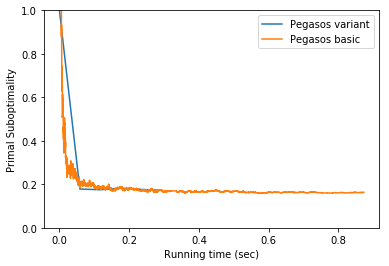

In [26]:
plt.plot(np.cumsum(result_peg_mod.rtime),result_peg_mod.primal, label="Pegasos variant")
plt.plot(np.cumsum(result_peg_basic.rtime),result_peg_basic.primal, label="Pegasos basic")
plt.xlabel("Running time (sec)")
plt.ylabel("Primal Suboptimality")
plt.ylim((0,1))
plt.legend()
plt.show()

### Other variants

Other implementations could have been followed. 

- A *mini-batch* version has been provided in the article. It has been shown that in practice no improvement is to see neither on running time nore in global performance. The only interesting aspect of this implementation is of course for parallelisation purposes but since we didn't plan to adapt our algorithm to this setting, we prefered not to follow this path.
- A *kernelized* version exists for non linear SVM, with Mercier kernels. We prefer for comparison purpose and to handle the basic version to focus on linear SVM.
- Include an *unregularized bias* in the loss which plays a role in unbalanced dataset: according to the authors, including an unregularized bias term does not significantly change the predictive performance for any of their data sets used. Furthermore, SDCA does not incorporate a bias term either. Nonetheless, there are clearly learning problems in specific settings (text processing for example).

## SDCA algorithm

### Preliminary functions

We first define functions that we will use in our algorithm

In [6]:
def w_from_alpha(alpha, X, lamb):
    """
    Obtain the primal weights from alpha

    Inputs:
        alpha: dual weights (n_samples)
        X: covariates matrix (n_samples*n_features)
        lamb: regularization (size 1)

    Outputs:
        primal weights (n_features)
    """
    n = X.shape[1]
    return (1 / (n * lamb)) * np.dot(X,alpha)

def hinge_sdca_update(y, W, X, n, lamb, alpha, gamma=0):
    """
    Updates alpha for hinge loss in SDCA

    Inputs:
        W: primal weights (n_features)
        X: covariates (n_features)
        y: label (size 1)
        lamb: regularization (size 1)

    Outputs:
        update of alpha (size 1)
    """
    n=X.shape[0]
    minim = min(1, ((1-np.dot(X.T,W)*y)*n*lamb/(np.power(np.linalg.norm(X), 2))+alpha*y))
    delta_alpha = y* max(0, minim)-alpha
    return (delta_alpha) 

def duality_gap(alpha, X, Y, lamb):
    """
    Computes the duality gap

    Inputs:
        alpha: dual weights (n_samples)
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        lamb: regularization (size 1)

    Outputs:
        duality gap
    """

    W = w_from_alpha(alpha, X, lamb)
    primal = cum_loss_primal(W, X.T, Y, lamb)
    dual = cum_loss_dual(alpha, X, Y, lamb)
    return primal - dual

def loss_tracking(X, Y, lamb, alpha, Alpha, primal_loss_track, dual_loss_track, gaps_track):
    """
    Records alpha and losses

    Inputs:
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        lamb: regularization (size 1)
        alpha: dual weights (n_samples)
        Alpha: matrix of dual weights (n_samples per epoch)
        primal_loss_track : vector of primal losses (one per epoch)
        dual_loss_track : vector of dual losses (one per epoch)
        gaps_track : vector of duality gaps (one per epoch)

    Outputs:
        Alpha and losses updated
    """
    Alpha.append(alpha.copy())
    W = w_from_alpha(alpha, X, lamb)
    primal_loss_track.append(cum_loss_primal(W, X.T, Y, lamb))
    dual_loss_track.append(cum_loss_dual(np.array(alpha), X, Y, lamb))
    gaps_track.append(duality_gap(np.array(alpha), X, Y, lamb))
    return (Alpha, primal_loss_track, dual_loss_track, gaps_track)
    

### SDCA algorithm, with permutation

We implement the SDCA algorithm, as presented in Shalev-Shwartz, Shai, and Tong Zhang. "Stochastic dual coordinate ascent methods for regularized loss minimization." *Journal of Machine Learning Research* 14.Feb (2013)

Instead of implementing the standard procedure, we choose the *SDCA-Perm*. As for the Pegasos algorithm, Shalew-Schwartz and Zhang suggest to use permutations of observations at each epoch. Thus, in sted of complete randomization, we run in epochs and each epoch employs a random permutation of the data.

In [7]:
def SDCA_perm (X, Y, n_epoch, T_0_ratio, epsilon, lamb):
    """
    SDCA Algorithm with a permutation of observations
    at each epoch.

    Inputs:
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        lamb: regularization (size 1)
        n_epoch: number of epochs (size 1)
        T_0_ratio: fraction indicating the share of iterations that we keep
                    to compute the final alpha and w (size 1)
        epsilon: duality gap threshold ending to exit the loop (size 1)
        lamb: regularization (size 1)

    Outputs:
        Alpha: matrix of weights (each row corresponds to an epoch)
        timelaps: vector of computational times (each element an epoch)
        primal_loss_track: vector of primal losses (each element an epoch)
        dual_loss_track: vector of dual losses (each element an epoch)
        gaps_track : vector of duality gaps (each element an epoch)
    """
    
    # To be closer to the article, we use the transpose of X in our computations
    X=X.T
    
    # We initialize
    n_samples = X.shape[1]
    n_features = X.shape[0]
    alpha= [0] * n_samples
    W = w_from_alpha(alpha, X, lamb)
    t = 0
    timelaps = [0]
    
    # We record the losses and alpha
    Alpha, primal_loss_track, dual_loss_track, gaps_track = [], [], [], []
    [Alpha, primal_loss_track, dual_loss_track, gaps_track] = (loss_tracking(X, Y, lamb, alpha, Alpha,
                                                                             primal_loss_track, dual_loss_track,
                                                                             gaps_track))
    
    
    while (gaps_track[-1] > epsilon) and (t < n_epoch) :
        start = time.perf_counter()
        indices = np.array(range(0, n_samples))
        np.random.shuffle(indices)
        for i in range(0, n_samples):
            j = indices[i]
            delta_alpha = hinge_sdca_update(Y[j], W, X[:,j], n_samples, lamb, alpha[j])
            alpha[j] += delta_alpha
            W += (1 / (lamb * n_samples)) * delta_alpha * X[:,j]
        end = time.perf_counter()
        timelaps.append(end - start)
        # After each epoch we record alpha and the losses
        [Alpha, primal_loss_track, dual_loss_track, gaps_track] = (loss_tracking(X, Y, lamb, alpha, Alpha,
                                                                             primal_loss_track, dual_loss_track,
                                                                             gaps_track))
        t += 1
    
    output = namedtuple("output", (["Alpha","timelaps", "primal_loss_track", 
                                    "dual_loss_track","gaps_track"]))
    out= output(Alpha, timelaps, primal_loss_track, dual_loss_track, gaps_track)
    return out

We run it on simulated data.

In [8]:
n_epoch = 20
T_0_ratio = 1/2
epsilon =1e-7 
lamb = 1e-1
sdca_perm = SDCA_perm(X_scale, Y, n_epoch, T_0_ratio, epsilon, lamb)

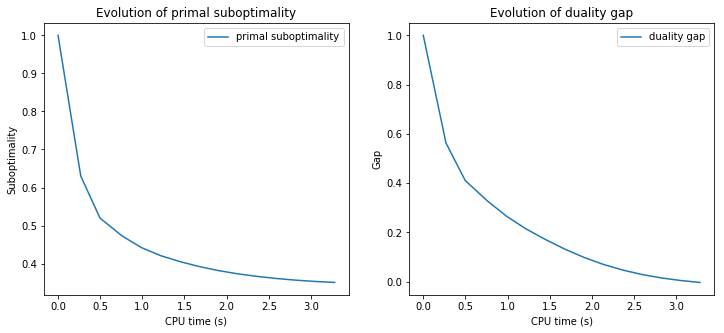

In [63]:
plt.figure(figsize=(12,5))
plt.plot([2,1])
plt.subplot(121)
plt.plot(np.cumsum(sdca_perm.timelaps), sdca_perm.primal_loss_track , label="primal suboptimality")
plt.ylabel("Suboptimality")
plt.xlabel("CPU time (s)")
plt.legend()
plt.title("Evolution of primal suboptimality")

plt.subplot(122)
plt.plot(np.cumsum(sdca_perm.timelaps), sdca_perm.gaps_track , label="duality gap")
plt.ylabel("Gap")
plt.xlabel("CPU time (s)")
plt.legend()
plt.title("Evolution of duality gap")
plt.show()

As expected, the duality gap converges to 0 while the primal suboptimality stabilizes smoothly.

### Algorithm, with decreasing steps

As mentionned by Shalev-Schwartz and Zhang in a [video of a research talk](https://www.microsoft.com/en-us/research/video/stochastic-dual-coordinate-ascent-and-its-proximal-extension-for-regularized-loss-minimization/) that they held about the paper, one of the weaknesses of SDCA with the hinge loss is that steps are small and constant at each iteration.

Therefore, they suggest that the step in $\frac{1}{n}$ can be transformed into a step in $\frac{1}{t}$, $t$ being the iteration. Therefore, the algorithm would first do large updates that will decrease over time.

In [10]:
def SDCA_decreasing_step (X, Y, n_epoch, T_0_ratio, epsilon, lamb, decreasing_step):
    """
    SDCA Algorithm with a permutation of observations
    at each epoch and decreasing steps

    Inputs:
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        lamb: regularization (size 1)
        n_epoch: number of epochs (size 1)
        T_0_ratio: fraction indicating the share of iterations that we keep
                    to compute the final alpha and w (size 1)
        epsilon: duality gap threshold ending to exit the loop (size 1)
        lamb: regularization (size 1)
        decreasing_step: indicates whether the step decreases with iterations (boolean)

    Outputs:
        Alpha: matrix of weights (each row corresponds to an epoch)
        timelaps: vector of computational times (each element an epoch)
        primal_loss_track: vector of primal losses (each element an epoch)
        dual_loss_track: vector of dual losses (each element an epoch)
        gaps_track : vector of duality gaps (each element an epoch)
    """
    # To be closer to the article, we use the transpose of X in our computations
    X=X.T
    
    # We initialize
    n_samples = X.shape[1]
    n_features = X.shape[0]
    alpha= [0] * n_samples
    W = w_from_alpha(alpha, X, lamb)
    t = 0
    timelaps = [0]
    
    # We record the losses and alpha
    Alpha, primal_loss_track, dual_loss_track, gaps_track = [], [], [], []
    [Alpha, primal_loss_track, dual_loss_track, gaps_track] = (loss_tracking(X, Y, lamb, alpha, Alpha,
                                                                             primal_loss_track, dual_loss_track,
                                                                             gaps_track))
    
    
    while (gaps_track[-1] > epsilon) and (t < n_epoch) :
        start = time.perf_counter()
        indices = np.array(range(0, n_samples))
        np.random.shuffle(indices)
        for i in range(0, n_samples):
            j = indices[i]
            
            if (decreasing_step == True):
                delta_alpha = hinge_sdca_update(Y[j], W, X[:,j], t**5, lamb, alpha[j])
            else:
                delta_alpha = hinge_sdca_update(Y[j], W, X[:,j], n_samples, lamb, alpha[j])
            alpha[j] += delta_alpha
            W += (1 / (lamb * n_samples)) * delta_alpha * X[:,j]
        end = time.perf_counter()
        timelaps.append(end - start)
        # After each epoch we record alpha and the losses
        [Alpha, primal_loss_track, dual_loss_track, gaps_track] = (loss_tracking(X, Y, lamb, alpha, Alpha,
                                                                             primal_loss_track, dual_loss_track,
                                                                             gaps_track))
        t += 1

    output = namedtuple("output", (["Alpha","timelaps", "primal_loss_track", 
                                    "dual_loss_track","gaps_track"]))
    out= output(Alpha, timelaps, primal_loss_track, dual_loss_track, gaps_track)
    return out

We deploy it on our simulated data.

In [11]:
n_epoch = 20
T_0_ratio = 1/2
epsilon =1e-7 
lamb = 1e-1
decreasing_step = True
sdca_dec = SDCA_decreasing_step(X_scale, Y, n_epoch, T_0_ratio, epsilon, lamb, decreasing_step)

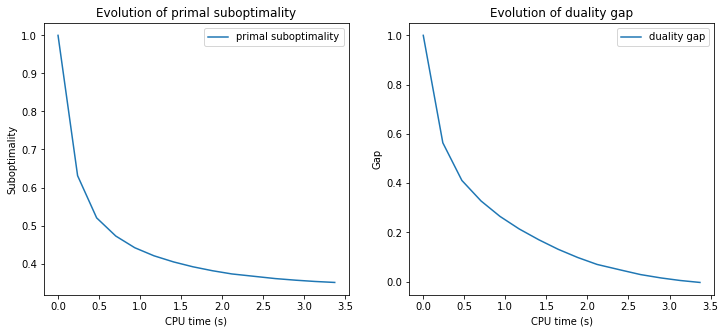

In [59]:
plt.figure(figsize=(12,5))
plt.plot([2,1])
plt.subplot(121)
plt.plot(np.cumsum(sdca_dec.timelaps), sdca_dec.primal_loss_track , label="primal suboptimality")
plt.ylabel("Suboptimality")
plt.xlabel("CPU time (s)")
plt.legend()
plt.title("Evolution of primal suboptimality")

plt.subplot(122)
plt.plot(np.cumsum(sdca_dec.timelaps), sdca_dec.gaps_track , label="duality gap")
plt.ylabel("Gap")
plt.xlabel("CPU time (s)")
plt.legend()
plt.title("Evolution of duality gap")
plt.show()

### Algorithme avec Stochastic Gradient Descent pour la premiere epoch

##### Cas du primal avec hinge loss

On appelle $S$ un ensemble de points, $x_i \in \mathbb{R}^{n}$ et les labels correspondants, $y_i \in \{−1,1\}$. On cherche un hyperplan qui minimiserait la hinge loss totale.

\begin{equation}
w^* = \underset{w}{\text{argmin }} L^{hinge}_S(w) = \underset{w}{\text{argmin }} \sum_i{l_{hinge}(w,x_i,y_i)}= \underset{w}{\text{argmin }} \sum_i{\max{\{0,1-y_iw\cdot x_i}\}}
\end{equation}

On identifie le gradient:

$$\frac{\partial{l_{hinge}}}{\partial w}=
\begin{cases}
  0  & y_iw\cdot x_i \geq 1 \\
  -y_ix & y_iw\cdot x_i < 1
\end{cases}$$

On obtient alors l'update suivant

$$w^{t+1}=\left(1-\frac{1}{t}\right)w^{t} - \frac{1|(y_i w^{t}\cdot x_i)}{\lambda t}x_i$$

##### Cas du dual avec hinge loss

Soit $t \in \{1,...,n\}$


Puisque pour la *Stochastic Gradient Descent*, on update selon une seule observation $t$ à chaque fois, l'objectif est de choisir le réel $\alpha_t$ qui maximise : 
$$ - \frac{1}{n} \phi_t^{\star}(-\alpha_t) - \frac{\lambda}{2} ||w^{t}||^2$$
Or, on a:
$$ \begin{align}
w^{t} = &  w^{t-1} + \Delta w\\
 = & w^{t-1} + \frac{1}{\lambda n}\sum_{i = 1}^{n} \Delta \alpha _{i} x_i\\
 = & w^{t-1} + \frac{1}{\lambda n} \Delta \alpha _{t} x_t \\
 = & w^{t-1} + \frac{1}{\lambda n} \alpha _{t} x_t \\
\end{align}$$
En effet, $\alpha_t$ est initialisé à 0 et le SGD sert à la première epoch seulement. On se retrouve donc à maximiser:

$$ - \phi_t^{\star}(-\alpha_t) - \frac{\lambda n}{2} ||w^{t-1} + \frac{1}{\lambda n} \alpha _{t} x_t ||^2$$

En développant : 
$$ \alpha_t y_t - \frac{\lambda n}{2} \left( ||w^{t-1}||^2 + 2 \frac{\alpha_t}{\lambda n} \langle w^{t-1}, x_t \rangle + \frac{\alpha_t^2}{\lambda^2 n^2}||x_t||^2 \right)$$

L'expression est concave du fait du terme de second ordre négatif. L'extremum sera donc un maximum. On applique la formule du maximizer dans un polynome de degré 2:
$$ \alpha_t^{\star}= \frac{\lambda n}{||x_t||^2} \left(y_t - x_t^T w^{t-1}\right)$$


Il faut toutefois éviter d'avoir une dual loss infinie. Il faut donc que $-\alpha_t^{\star}y \in [-1,0] \Leftrightarrow \alpha_t^{\star}y \in [0,1]$

On peut donc adapter l'algorithme pour qu'il incorpore un SGD pour la première epoch.

On commence par ajouter la fonction d'update du SGD

In [14]:
def hinge_sgd_update(y, W, X, t, lamb):    
    """
    Compute alpha update in SGD for first epoch

    Inputs:
        y: label (size 1)
        W: primal weights (n_features)
        X: covariates (n_features)
        t: iteration (size 1)
        lamb: regularization (size 1)

    Outputs:
        update of alpha (size 1)
    """
    alpha_star=((lamb * t) /  (np.linalg.norm(X)**2)) * (y - np.dot(X.T, W))
    if (alpha_star *y <0) and (alpha_star *y >1):
        print("Error SGD")
    return alpha_star

In [15]:
def SDCA_sgd (X, Y, n_epoch, T_0_ratio, epsilon, lamb, SGD_init):
    """
    SDCA Algorithm with a permutation of observations
    at each epoch and a first epoch using Stochastic 
    Gradient Descent to initialize alpha

    Inputs:
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        lamb: regularization (size 1)
        n_epoch: number of epochs (size 1)
        T_0_ratio: fraction indicating the share of iterations that we keep
                    to compute the final alpha and w (size 1)
        epsilon: duality gap threshold ending to exit the loop (size 1)
        lamb: regularization (size 1)
        sgd: indicates whether to use SGD for the first epoch (boolean)

    Outputs:
        Alpha: matrix of weights (each row corresponds to an epoch)
        timelaps: vector of computational times (each element an epoch)
        primal_loss_track: vector of primal losses (each element an epoch)
        dual_loss_track: vector of dual losses (each element an epoch)
        gaps_track : vector of duality gaps (each element an epoch)
    """
    
    # To be closer to the article, we use the transpose of X in our computations
    X=X.T
    
    # We initialize
    n_samples = X.shape[1]
    n_features = X.shape[0]
    alpha= [0] * n_samples
    W = w_from_alpha(alpha, X, lamb)
    t = 0
    timelaps = [0]
    
    # We record the losses and alpha
    Alpha, primal_loss_track, dual_loss_track, gaps_track = [], [], [], []
    [Alpha, primal_loss_track, dual_loss_track, gaps_track] = (loss_tracking(X, Y, lamb, alpha, Alpha,
                                                                             primal_loss_track, dual_loss_track,
                                                                             gaps_track))
    
    
    while (gaps_track[-1] > epsilon) and (t < n_epoch) :
        start = time.perf_counter()
        indices = np.array(range(0, n_samples))
        np.random.shuffle(indices)
        for i in range(0, n_samples):
            j = indices[i]
            
            # Initialization using SGD if desired
            if (t==0) and (SGD_init==True):
                alpha[i] = hinge_sgd_update(Y[i], W, X[:, i], i, lamb)
                # Due to the evolving dimension of alpha, we compute w manually
                W *= float(i) / float(i + 1)
                W += (1 / (lamb * (i + 1))) * np.array(alpha[i]) * np.array(X[:, i])
                
             # SDCA for the rest
            else:
                delta_alpha = hinge_sdca_update(Y[j], W, X[:,j], n_samples, lamb, alpha[j])
                alpha[j] += delta_alpha
                W += (1 / (lamb * n_samples)) * delta_alpha * X[:,j]
        
        
        end = time.perf_counter()
        timelaps.append(end - start)
        # After each epoch we record alpha and the losses
        [Alpha, primal_loss_track, dual_loss_track, gaps_track] = (loss_tracking(X, Y, lamb, alpha, Alpha,
                                                                             primal_loss_track, dual_loss_track,
                                                                             gaps_track))
        t += 1
    
    output = namedtuple("output", (["Alpha","timelaps", "primal_loss_track", 
                                    "dual_loss_track","gaps_track"]))
    out= output(Alpha, timelaps, primal_loss_track, dual_loss_track, gaps_track)
    return out

#### Résultats pour les données simulées

In [16]:
n_epoch = 20
T_0_ratio = 1/2
epsilon =1e-7 
lamb = 1e-1
SGD_init = True

sdca_sgd = SDCA_sgd(X_scale, Y, n_epoch, T_0_ratio, epsilon, lamb, SGD_init)

On regarde l'évolution de la perte primale et du duality gap

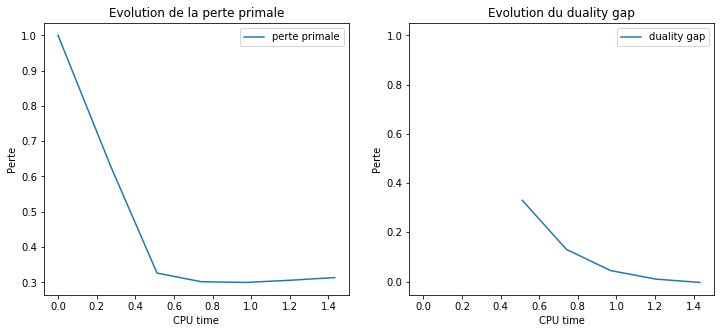

In [17]:
plt.figure(figsize=(12,5))
plt.plot([2,1])
plt.subplot(121)
plt.plot(np.cumsum(sdca_sgd.timelaps), sdca_sgd.primal_loss_track , label="perte primale")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution de la perte primale")

plt.subplot(122)
plt.plot(np.cumsum(sdca_sgd.timelaps), sdca_sgd.gaps_track , label="duality gap")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution du duality gap")
plt.show()

On regarde l'évolution de la perte primale et du duality gap

### Comparaison des performances des différentes versions

In [18]:
T = 8
T_0_ratio = 1/2
epsilon =1e-7 
lamb = 1e-1
SGD_init = True
decreasing_step = True

sdca_perm = SDCA_perm(X_scale, Y, n_epoch, T_0_ratio, epsilon, lamb)

sdca_dec = SDCA_decreasing_step(X_scale, Y, n_epoch, T_0_ratio, epsilon, lamb, decreasing_step)

sdca_sgd = SDCA_sgd(X_scale, Y, n_epoch, T_0_ratio, epsilon, lamb, SGD_init)

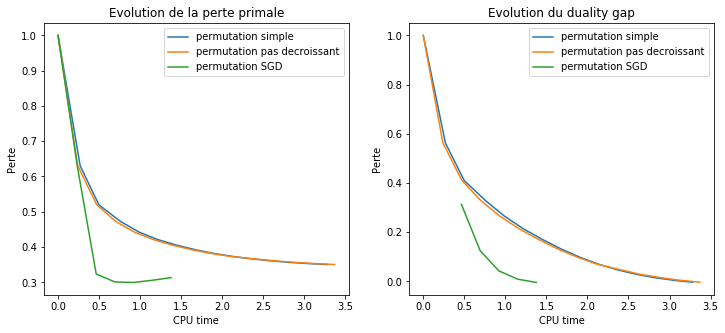

In [19]:
plt.figure(figsize=(12,5))
plt.plot([2,1])
plt.subplot(121)
plt.plot(np.cumsum(sdca_perm.timelaps), sdca_perm.primal_loss_track , label="permutation simple")
plt.plot(np.cumsum(sdca_dec.timelaps), sdca_dec.primal_loss_track , label="permutation pas decroissant")
plt.plot(np.cumsum(sdca_sgd.timelaps), sdca_sgd.primal_loss_track , label="permutation SGD")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution de la perte primale")

plt.subplot(122)
plt.plot(np.cumsum(sdca_perm.timelaps), sdca_perm.gaps_track, label="permutation simple")
plt.plot(np.cumsum(sdca_dec.timelaps), sdca_dec.gaps_track, label="permutation pas decroissant")
plt.plot(np.cumsum(sdca_sgd.timelaps), sdca_sgd.gaps_track, label="permutation SGD")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution du duality gap")
plt.show()

## 2. Experimental comparison

### Setting the framework

A key feature of algorithm implementation that we, for now, avoid to deal with is the **stopping criterion**. Indeed we know to set a common framework for performance comparison purposes. Nevertheless, if in the SDCA definition is included a stopping rule -namely a duality gap lower than a given threshold-, the Pegasos is not conceived with an intrinsec stopping rule.

After several experiments and readings (especially a conference by Bottou -http://leon.bottou.org/slides/largescale/lstut.pdf), we came with the following setting.

**Process**: Since we want to assess the performance both on the *running time* and on the *accuracy* of the final prediction, we create a split between a training set and a validation set over which to monitor the convergence. Why ? Because since we want to be able to generalize out of the sample our results, we think that even in the optimisation process, the metric should be estimated on a blind dataset.

**Metric**: Several metrics could be used, but because of the spirit of the algorithm we've chosen to focus on the primal suboptimality as in Shalev-Shwartz et al. (2007) on the validation set.

**Stopping criteria**: As explained in Bottou, we should stop the gradient descent when the cost function stops descreasing. For evaluating this phenomenon, we set the difference between the primal function previous and current epoch to be smaller than a given threshold. After several experiments, 0.0001 seems to be a good value, but it remains as hyperparameters in our function in case of.

**Final goodness-of-fit evaluation**: Moreover to push a little further in this direction, we split before any computation, the original dataset in two, a training one and a test one, so that after all optimisation of both algorithm their performances are computed on a totally new dataset.

**In practice**: We split the original dataset in a training (80%) and a test (20%) set. Then each algorithm has for first step a partitioning of the train set in a training (80%) set and a validation (20%) set, such that the stopping criteria is computed over the validation set. In the end our dataset kept for estimation entails circa two thirds of the original one.

### Pegasos

In [27]:
stop_thresh = 0.001
test_ratio = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_ratio, shuffle=True, random_state = 0)

In [28]:
def pegasos(X,Y,lamb, test_ratio=test_ratio, stop_thresh=stop_thresh, show_output=True): 
    
    """
    Implement Pegasos in its variant definition 
    with stopping criterion on primal function estimated on a test dataset
    
    Inputs:
        X: covariates matrix (n_samples,n_features) 
        Y: labels vector, coded as (-1,1), (n_samples)
        lamb: regularization paramater
        n_epoch: number of epoch
        show_output: indicates if the algorithm should print results (boolean)
    
    Outputs:
        primal_: primal suboptimality at each iteration (n_iter)
        rtime: running time for each iteration (n_iter)
        w: final weights (n_features)
    """
    
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_ratio, shuffle=True, 
                                                        random_state = 0)
    m = len(Y_train) #number of observations
    n_features = X_train.shape[1]

    #Initialisation
    primal_val= []
    rtime = []
    w= np.zeros(n_features) 
    i=0
    diff = stop_thresh+1 # number greater than stop_thresh
    
    # First outputs
    cost_val = cum_loss_primal(w,X_val,Y_val, lamb)
    primal_val.append(cost_val)
    rtime.append(0)
    
    
    while (abs(diff) > stop_thresh):
        
        start_time = time.perf_counter()
        
        # Shuffle datasets
        p= np.random.permutation(m)
        Xs=X_train[p]
        Ys=Y_train[p]
        
        # Estimation step
        for t in range(0,m):
            eta = 1/(lamb*(t+1))
            x, y= Xs[t], Ys[t]
            subgrad= y*(w.dot(x))
            if subgrad <1:
                w=(1-eta*lamb)*w+ (eta*y)*x
            else:
                w=(1-eta*lamb)*w
                    
        # Validation step
        cost_val = cum_loss_primal(w,X_val,Y_val, lamb)
        primal_val.append(cost_val)
        
        if i>2:
            diff = primal_val[i] - primal_val[i-1]
        
        i+=1
        rtime.append(time.perf_counter() - start_time)

    if (show_output==True):
        print("total number of epoch:",i) 
        print("running time:",sum(rtime), "sec") 

        print("After optimisation")
        print("Primal on validation", cost_val)
        
    output = namedtuple("output", ["primal_val","rtime", "w"])
    out= output(primal_val, rtime, w)
    return out

In [29]:
result_peg = pegasos(X_train, Y_train, lamb)

total number of epoch: 35
running time: 1.3843951870039746 sec
After optimisation
Primal on validation 0.192216691708


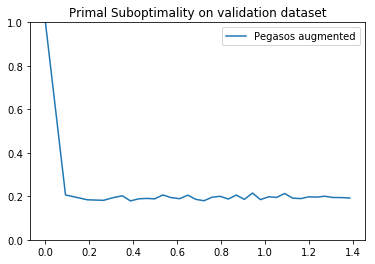

In [30]:
plt.plot(np.cumsum(result_peg.rtime),result_peg.primal_val, label = "Pegasos augmented")
plt.ylim((0,1))
plt.legend()
plt.title("Primal Suboptimality on validation dataset")
plt.show()


### SDCA

We perform the same thing on our SDCA algorithm using a SGD initilization for the first epoch.

In [31]:
def SDCA (X, Y, lamb, stop_thresh = stop_thresh, T_0_ratio =1/2, SGD_init=True, show_output=False):
    """
    SDCA Algorithm with a permutation of observations
    at each epoch and a first epoch using Stochastic 
    Gradient Descent to initialize alpha and
    stopping criterion on primal function estimated on a test dataset

    Inputs:
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        lamb: regularization (size 1)
        stop_thresh: primal loss threshold to exit the loop (size 1)
        T_0_ratio: fraction indicating the share of iterations that we keep
                    to compute the final alpha and w (size 1)
        SGD_init: indicates whether to use SGD for the first epoch (boolean)
        show_output: indicates if the algorithm should print results (boolean)

    Outputs:
        Alpha: matrix of weights (each row corresponds to an epoch)
        timelaps: vector of computational times (each element an epoch)
        primal_loss_track: vector of primal losses (each element an epoch)
        dual_loss_track: vector of dual losses (each element an epoch)
        gaps_track : vector of duality gaps (each element an epoch)
        W_bar: final weights, estimated by average method (n_features)
        W_rand: final weights, estimated by random method (n_features)
    """
    
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_ratio, shuffle=True, 
                                                        random_state = 0)
    
    # To be closer to the article, we use the transpose of X in our computations
    X_train=X_train.T
    X_val=X_val.T
    
    # We initialize
    n_samples = X_train.shape[1]
    n_features = X_train.shape[0]
    alpha= [0] * n_samples
    W = w_from_alpha(alpha, X_train, lamb)
    t = 0
    timelaps = [0]
    
    # We record alpha and the loss on validation set
    Alpha, primal_loss_track = [], []
    Alpha.append(alpha.copy())
    W = w_from_alpha(alpha, X_train, lamb)
    primal_loss_track.append(cum_loss_primal(W, X_val.T, Y_val, lamb))
    
    m = len(Y_train) #number of observations
    
    diff=stop_thresh+1
    while (diff > stop_thresh):
        start = time.perf_counter()
        indices = np.array(range(0, n_samples))
        np.random.shuffle(indices)
        for i in range(0, n_samples):
            j = indices[i]
            
            # Initialization using SGD if desired
            if (t==0) and (SGD_init==True):
                alpha[i] = hinge_sgd_update(Y_train[i], W, X_train[:, i], i, lamb)
                # Due to the evolving dimension of alpha, we compute w manually
                W *= float(i) / float(i + 1)
                W += (1 / (lamb * (i + 1))) * np.array(alpha[i]) * np.array(X_train[:, i])
                
             # SDCA for the rest
            else:
                delta_alpha = hinge_sdca_update(Y_train[j], W, X_train[:,j], n_samples, lamb, alpha[j])
                alpha[j] += delta_alpha
                W += (1 / (lamb * n_samples)) * delta_alpha * X_train[:,j]
        
        # Validation step     
        cost_val = cum_loss_primal(W,X_val.T,Y_val, lamb)
        primal_loss_track.append(cost_val)
        
        if t>2:
            diff = primal_loss_track[t] - primal_loss_track[t-1]
        
        end = time.perf_counter()
        timelaps.append(end - start)
        Alpha.append(alpha.copy())
        t += 1
        
    # Once it has converged we collect the weights using alpha
        # average method
    alpha_bar = np.mean(Alpha[-int(T_0_ratio*len(Alpha)):],axis=0)
    W_bar = w_from_alpha(alpha_bar,X_train, lamb)
    
        # random method
    k = np.random.randint(int(T_0_ratio*len(Alpha)),len(Alpha)-1)
    alpha_rand = Alpha[k]
    W_rand=w_from_alpha(alpha_rand, X_train, lamb)
    
    if (show_output==True):
        print("total number of epoch:",t) 
        print("running time:",sum(timelaps), "sec") 

        print("After optimisation")
        print("Primal on validation", cost_val)

    output = namedtuple("output", (["Alpha","timelaps", "primal_loss_track", "W_bar","W_rand"]))
    out= output(Alpha, timelaps, primal_loss_track, W_bar, W_rand)
    return out

In [32]:
result_sdca = SDCA(X_train, Y_train, lamb, show_output= True)

total number of epoch: 4
running time: 0.60273016699648 sec
After optimisation
Primal on validation 0.162245026187


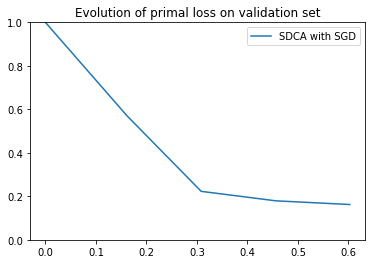

In [33]:
plt.plot(np.cumsum(result_sdca.timelaps),result_sdca.primal_loss_track, label = "SDCA with SGD")
plt.ylim((0,1))
plt.legend()
plt.title("Evolution of primal loss on validation set")
plt.show()

### Comparison

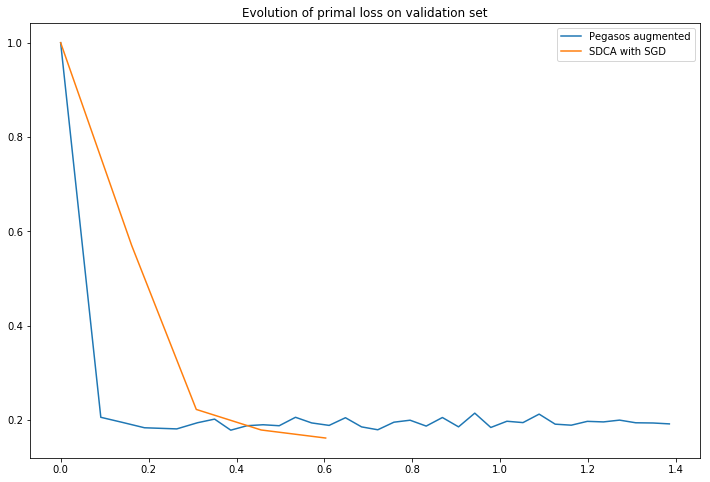

In [34]:
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(result_peg.rtime),result_peg.primal_val, label = "Pegasos augmented")
plt.plot(np.cumsum(result_sdca.timelaps),result_sdca.primal_loss_track, label = "SDCA with SGD")
plt.legend()
plt.title("Evolution of primal loss on validation set")
plt.show()

## Assessing goodness-of-fit
We now use the untouched test dataset to compare traditionnal classification metric between our two algorithms.

In [35]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

def print_f1_score(Y,Y_pred, label):
    f1_neg= f1_score(Y, Y_pred,pos_label=-1, average='binary')
    f1_pos= f1_score(Y, Y_pred,pos_label=1, average='binary')
    print("f1 "+label+ "(on pos=1)",f1_pos)
    print("f1 "+label+ "(on pos=-1)",f1_neg)
    
    return list((f1_neg, f1_pos))

    
def plot_confusion_matrix(Y,y_pred, label, cmap=plt.cm.Oranges, show_graph=True):
    title='Confusion matrix - ' +label
    cm=confusion_matrix(Y, y_pred)
    print('Confusion matrix - ' +label)
    print(cm)
    if show_graph == True:
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        plt.tight_layout()
        plt.ylabel('True outcome')
        plt.xlabel('Predicted outcome')
    
def plot_roc(Y,Y_pred,label, col='orange'):
    fpr, tpr, _ =metrics.roc_curve(Y, Y_pred)
    roc_auc = auc(fpr, tpr)

    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='SVM ' +label+ ' - auc = %0.3f)' % roc_auc,color=col)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')

def assessing_accuracy(Y,Y_pred,label):
    f1=print_f1_score(Y,Y_pred, label)
    plot_confusion_matrix(Y,Y_pred,label)
    plt.show()
    return f1
    

In [36]:
y_pred_peg = np.sign(X_test.dot(result_peg.w))

f1 Pegasos(on pos=1) 0.932730923695
f1 Pegasos(on pos=-1) 0.933266932271
Confusion matrix - Pegasos
[[937  71]
 [ 63 929]]


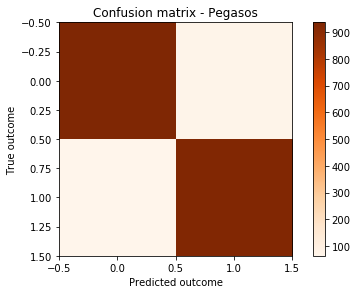

In [37]:
f1_peg=assessing_accuracy(Y_test, y_pred_peg, "Pegasos")

f1 SDCA(on pos=1) 0.962330487192
f1 SDCA(on pos=-1) 0.962667994027
Confusion matrix - SDCA
[[967  41]
 [ 34 958]]


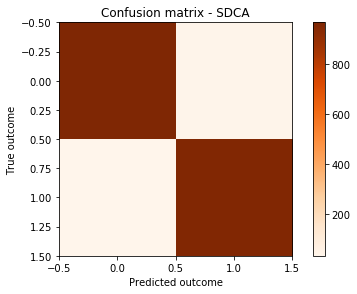

In [38]:
y_pred_sdca = np.sign(X_test.dot(result_sdca.W_bar))
f1_sdca = assessing_accuracy(Y_test, y_pred_sdca, "SDCA")

### Comparison

Confusion matrix - Pegasos
[[937  71]
 [ 63 929]]
Confusion matrix - SDCA
[[967  41]
 [ 34 958]]


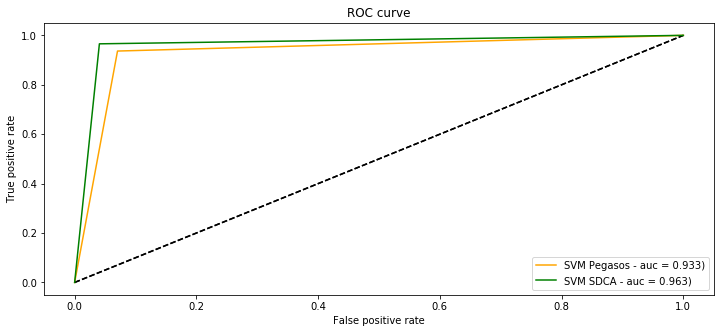

,Pegasos,SDCA
f1 on -1,0.933267,0.962668
f1 on 1,0.932731,0.962330


In [39]:
plot_confusion_matrix(Y_test,y_pred_peg, "Pegasos", show_graph=False)
plot_confusion_matrix(Y_test,y_pred_sdca, "SDCA", show_graph=False)

plt.figure(figsize=(12,5))
plot_roc(Y_test,y_pred_peg, "Pegasos")
plot_roc(Y_test,y_pred_sdca, "SDCA", col="green")
plt.show()

f1 = {'Pegasos': f1_peg, 'SDCA': f1_sdca}
pd.DataFrame(f1, index= ('f1 on -1', 'f1 on 1'))

## Real application

### Preprocessing data

This step is crucial since SVM is a distance-based algorithm, that use a metric the Euclidian one. Thus we have to make sure that all features are spread along similar range, to take consider all features in an uniform way

In [40]:
import requests
import urllib.request

presentation = "https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.names"
f = requests.get(presentation)
furl = urllib.request.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data")
df = pd.read_csv(furl, names=["age", "edu", "edu_h","nb_child","religion","work","occ_h","stand_liv","media","contraception"])
df.describe()

,age,edu,edu_h,nb_child,religion,work,occ_h,stand_liv,media,contraception
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
mean,32.538357,2.958588,3.429735,3.261371,0.850645,0.749491,2.137814,3.133741,0.073999,1.919891
std,8.227245,1.014994,0.816349,2.358549,0.356559,0.433453,0.864857,0.976161,0.261858,0.876376
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000
75%,39.000000,4.000000,4.000000,4.000000,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000
max,49.000000,4.000000,4.000000,16.000000,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000


In [41]:
print(f.text)

1. Title: Contraceptive Method Choice

2. Sources:
   (a) Origin:  This dataset is a subset of the 1987 National Indonesia
                Contraceptive Prevalence Survey
   (b) Creator: Tjen-Sien Lim (limt@stat.wisc.edu)
   (c) Donor:   Tjen-Sien Lim (limt@stat.wisc.edu)
   (c) Date:    June 7, 1997

3. Past Usage:
   Lim, T.-S., Loh, W.-Y. & Shih, Y.-S. (1999). A Comparison of
   Prediction Accuracy, Complexity, and Training Time of Thirty-three
   Old and New Classification Algorithms. Machine Learning. Forthcoming.
   (ftp://ftp.stat.wisc.edu/pub/loh/treeprogs/quest1.7/mach1317.pdf or
   (http://www.stat.wisc.edu/~limt/mach1317.pdf)

4. Relevant Information:
   This dataset is a subset of the 1987 National Indonesia Contraceptive
   Prevalence Survey. The samples are married women who were either not 
   pregnant or do not know if they were at the time of interview. The 
   problem is to predict the current contraceptive method choice 
   (no use, long-term methods, or short-term m

#### Outcome preprocessing

In [42]:
# Original encoding
print(df.contraception.value_counts())

# Encoding (-1,1)
Y = df.contraception
Y = np.where((Y!= 1) , 1, -1)
print(np.unique(Y, return_counts=True))

1    629
3    511
2    333
Name: contraception, dtype: int64
(array([-1,  1]), array([629, 844]))


#### Covariates preprocessing

In [43]:
# Select covariates
X = df
X=X.drop("contraception", axis=1)

n_features = X.shape[1]
n_samples =  X.shape[0]

X.describe()

,age,edu,edu_h,nb_child,religion,work,occ_h,stand_liv,media
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
mean,32.538357,2.958588,3.429735,3.261371,0.850645,0.749491,2.137814,3.133741,0.073999
std,8.227245,1.014994,0.816349,2.358549,0.356559,0.433453,0.864857,0.976161,0.261858
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000
75%,39.000000,4.000000,4.000000,4.000000,1.000000,1.000000,3.000000,4.000000,0.000000
max,49.000000,4.000000,4.000000,16.000000,1.000000,1.000000,4.000000,4.000000,1.000000


In [44]:
# Spot manually categorical variable
index_cat=list(range(0,n_features))
del index_cat[0]
del index_cat[2]

print(X.columns[index_cat])

Index(['edu', 'edu_h', 'religion', 'work', 'occ_h', 'stand_liv', 'media'], dtype='object')


In [45]:
def process_df(X, index_cat):
    
    n_features = X.shape[1]
    nb_num = n_features - len(index_cat) # number of numerical features

    # OneHot encoding of categorical variable
    enc = preprocessing.OneHotEncoder(categorical_features=index_cat)
    enc.fit(X)  
    X_proc = enc.transform(X).toarray()
    
    n_features_enc = X_proc.shape[1] # new number of features
    
    # Scaling numerical variables (z-score)
    #trick: use output ordering of OneHotEncoder that set numerical features in last positions
    index_num = list(range(0,n_features_enc)) 
    index_num = index_num[-nb_num:]
    
    X_num = X_proc[:,index_num]
    X_num = preprocessing.scale(X_num)
    X_proc[:,index_num] = X_num
    
    return X_proc

In [46]:
X_proc = process_df(X, index_cat)
pd.DataFrame(X_proc).describe()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,...,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1.473000e+03,1.473000e+03
mean,0.103191,0.226748,0.278344,0.391718,0.029871,0.120842,0.238968,0.610319,0.149355,0.850645,...,0.397149,0.018330,0.087576,0.155465,0.292600,0.464358,0.926001,0.073999,1.848111e-16,1.011486e-16
std,0.304311,0.418871,0.448336,0.488300,0.170289,0.326054,0.426598,0.487843,0.356559,0.356559,...,0.489473,0.134187,0.282774,0.362470,0.455111,0.498897,0.261858,0.261858,1.000340e+00,1.000340e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.010877e+00,-1.383257e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-7.949900e-01,-9.591234e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-6.545811e-02,-1.108563e-01
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,7.856625e-01,3.132772e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.001549e+00,5.402879e+00


## Train algorithm

In [47]:
# Split train/test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_proc, Y, 
                                                    test_size=test_ratio, 
                                                    shuffle=True, random_state = 0)

100% (4 of 4) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02


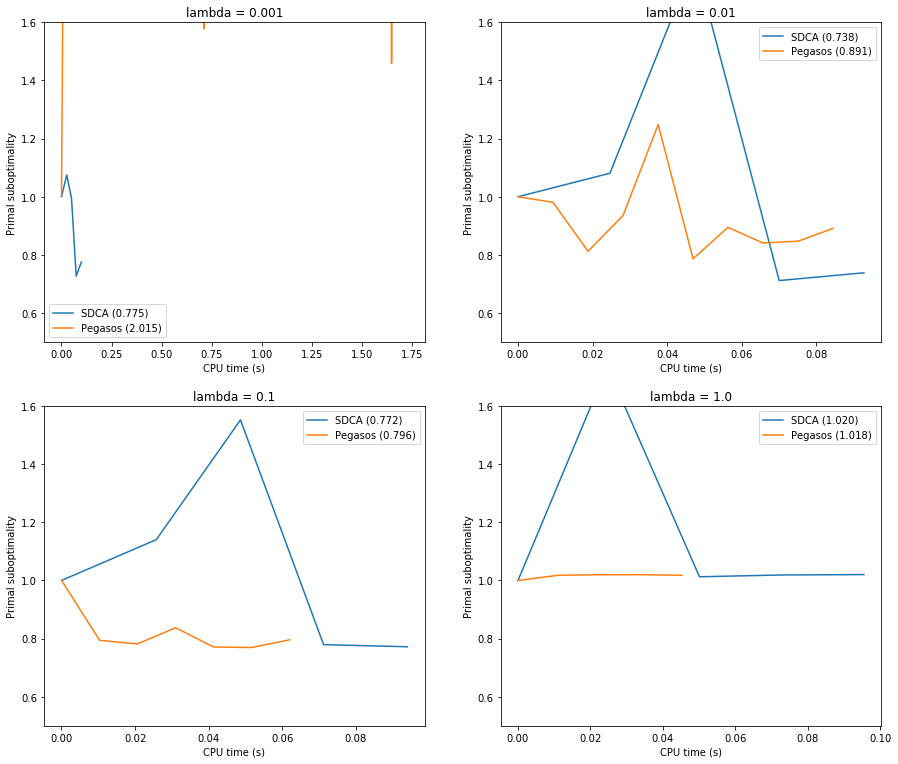

In [48]:
from progressbar import ProgressBar

result=[]
range_to_test = range (-3,1)

pbar = ProgressBar()

for i in pbar(range_to_test):
    lamb = 1e1**(i)
    outcome = namedtuple("outcome", (["lamb","sdca","pegasos"]))
    out= (outcome(lamb,
                  SDCA(X_train, Y_train, lamb, stop_thresh= 0.01,show_output= False), 
                  pegasos(X_train, Y_train, lamb, stop_thresh= 0.01,show_output= False)))
    result.append(out)
    

plt.figure(figsize=(15,20))
for i in range(0,len(range_to_test)):
    final_opt_sdca = result[i].sdca.primal_loss_track[-1]
    final_opt_peg = result[i].pegasos.primal_val[-1]
    index=int(str(int((len(range_to_test)+1)/2)+1)+'2'+str(i+1))
    plt.subplot(index)
    plt.plot(np.cumsum(result[i].sdca.timelaps), result[i].sdca.primal_loss_track , label="SDCA (%0.3f)" % final_opt_sdca)
    plt.plot(np.cumsum(result[i].pegasos.rtime), result[i].pegasos.primal_val , label="Pegasos (%0.3f)" % final_opt_peg)
    plt.ylabel("Primal suboptimality")
    plt.xlabel("CPU time (s)")
    plt.ylim((0.5,1.6))
    plt.legend()
    title = 'lambda = '+str(result[i].lamb)
    plt.title(title)
    print()

plt.show()

In [49]:
lamb=0.1
stop_thresh = 0.01
n_iter = 20

primal_peg = []
primal_sdca = []
w_peg = []
w_sdca = []

for i in range(0,n_iter):
    peg = pegasos(X_train, Y_train, lamb, stop_thresh= stop_thresh,show_output= False)
    sdca = SDCA(X_train, Y_train, lamb, stop_thresh= stop_thresh, show_output= False)
    
    primal_peg.append(peg.primal_val[-1])
    primal_sdca.append(sdca.primal_loss_track[-1])
    
    w_peg.append(peg.w)
    w_sdca.append(sdca.W_bar)
    
print("Running time (sec)")
print("Pegasos", np.sum(peg.rtime))
print("SDCA", np.sum(sdca.timelaps))

Running time (sec)
Pegasos 0.0514866200028
SDCA 0.0925056470005


In [50]:
result_peg_primal = np.mean(primal_peg)
result_sdca_primal = np.mean(primal_sdca)
print("Primal suboptimality on validation set")
print("Pegasos", result_peg_primal)
print("SDCA", result_sdca_primal)

Primal suboptimality on validation set
Pegasos 0.783369648371
SDCA 0.773695358105


In [51]:
result_peg_w = np.mean(w_peg, axis=0)
result_sdca_w = np.mean(w_sdca, axis=0)

### Goodness-of-fit

In [52]:
y_pred_sdca = np.sign(X_test.dot(result_sdca_w))
y_pred_peg = np.sign(X_test.dot(result_peg_w))


f1 Pegasos(on pos=1) 0.728606356968
f1 Pegasos(on pos=-1) 0.386740331492
Confusion matrix - Pegasos
[[ 35 102]
 [  9 149]]


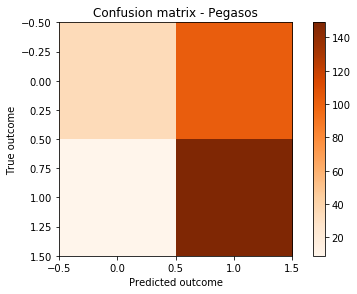

f1 SDCA(on pos=1) 0.744791666667
f1 SDCA(on pos=-1) 0.52427184466
Confusion matrix - SDCA
[[ 54  83]
 [ 15 143]]


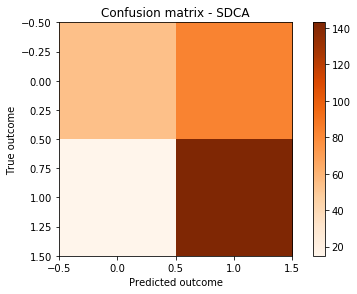

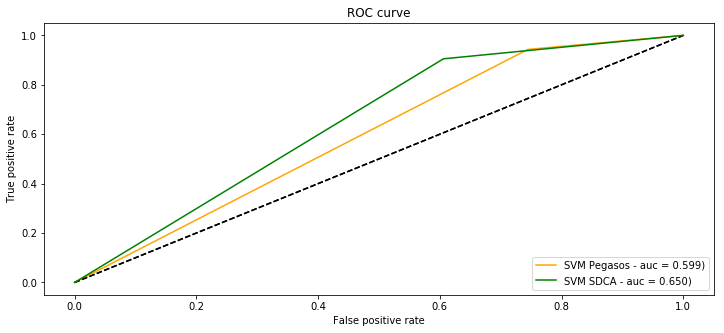

           Pegasos      SDCA
f1 on -1  0.386740  0.524272
f1 on 1   0.728606  0.744792


In [53]:
f1_peg=assessing_accuracy(Y_test, y_pred_peg, "Pegasos")
f1_sdca=assessing_accuracy(Y_test, y_pred_sdca, "SDCA")

plt.figure(figsize=(12,5))
plot_roc(Y_test,y_pred_peg, "Pegasos")
plot_roc(Y_test,y_pred_sdca, "SDCA", col="green")
plt.show()


f1 = {'Pegasos': f1_peg, 'SDCA': f1_sdca}
print(pd.DataFrame(f1, index= ('f1 on -1', 'f1 on 1')))

## Real application: second database

The [skin dataset](https://archive.ics.uci.edu/ml/datasets/Skin+Segmentation#) is collected by randomly sampling B,G,R values from face images of various age groups (young, middle, and old), race groups (white, black, and asian), and genders obtained from FERET database and PAL database. Total learning sample size is 245057; out of which 50859 is the skin samples and 194198 is non-skin samples.

In [54]:
skin_data = np.loadtxt('skin.txt', dtype='int')
X=skin_data[:,0:3]
Y=skin_data[:,-1]
df = pd.DataFrame(skin_data, columns=["B", "G", "R","skin"])
df.describe()

,B,G,R,skin
count,245057.000000,245057.000000,245057.000000,245057.000000
mean,125.065446,132.507327,123.177151,1.792461
std,62.255653,59.941197,72.562165,0.405546
min,0.000000,0.000000,0.000000,1.000000
25%,68.000000,87.000000,70.000000,2.000000
50%,139.000000,153.000000,128.000000,2.000000
75%,176.000000,177.000000,164.000000,2.000000
max,255.000000,255.000000,255.000000,2.000000


### Preprocessing data

#### Outcome preprocessing

In [55]:
# Original encoding
print(df.skin.value_counts())

# Encoding (-1,1)
Y = np.where((Y!= 1) , 1, -1)
print(np.unique(Y, return_counts=True))

2    194198
1     50859
Name: skin, dtype: int64
(array([-1,  1]), array([ 50859, 194198]))


#### Covariates preprocessing
There is no need to preprocess the features for this dataset. Each feature corresponds to an integer between 0 and 255, refering to the three components of color.

## Train algorithm

In [56]:
# Split train/test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=test_ratio, 
                                                    shuffle=True, random_state = 0)

N/A% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--/home/gauthier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
100% (6 of 6) |##########################| Elapsed Time: 0:15:02 Time:  0:15:02


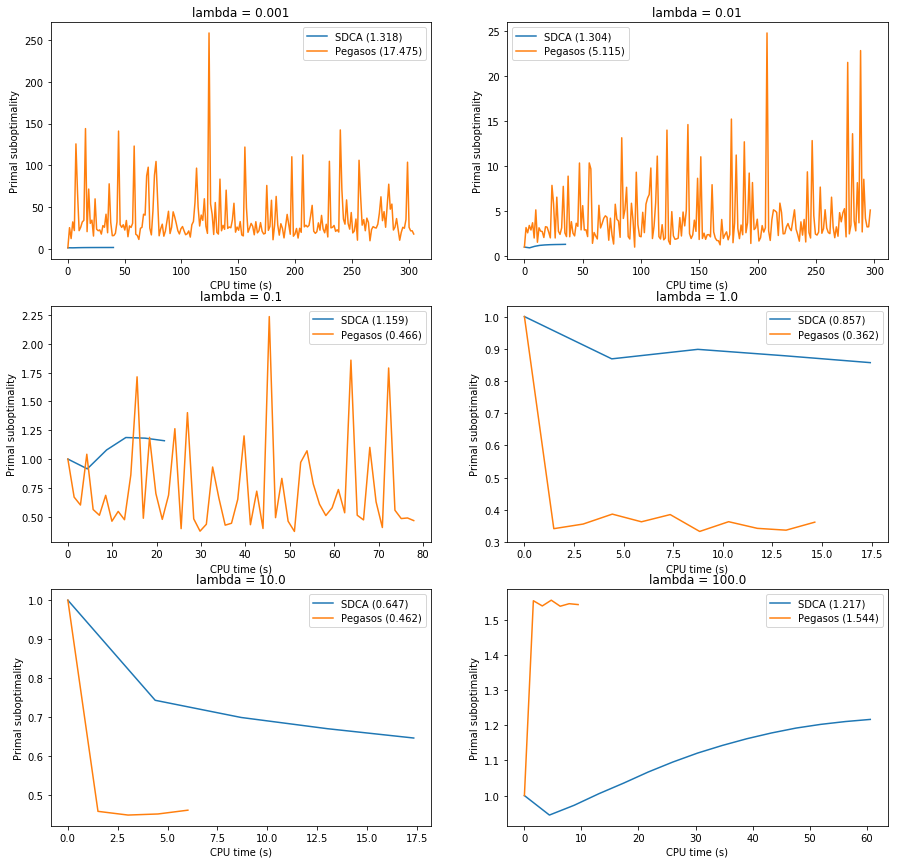

In [57]:
result=[]
range_to_test = range (-3,3)

pbar = ProgressBar()

for i in pbar(range_to_test):
    lamb = 1e1**(i)
    outcome = namedtuple("outcome", (["lamb","sdca","pegasos"]))
    out= (outcome(lamb,
                  SDCA(X_train, Y_train, lamb, stop_thresh= 0.01, SGD_init=False, show_output= False), 
                  pegasos(X_train, Y_train, lamb, stop_thresh= 0.01,show_output= False)))
    result.append(out)
    

plt.figure(figsize=(15,20))
for i in range(0,len(range_to_test)):
    final_opt_sdca = result[i].sdca.primal_loss_track[-1]
    final_opt_peg = result[i].pegasos.primal_val[-1]
    index=int(str(int((len(range_to_test)+1)/2)+1)+'2'+str(i+1))
    plt.subplot(index)
    plt.plot(np.cumsum(result[i].sdca.timelaps), result[i].sdca.primal_loss_track , label="SDCA (%0.3f)" % final_opt_sdca)
    plt.plot(np.cumsum(result[i].pegasos.rtime), result[i].pegasos.primal_val , label="Pegasos (%0.3f)" % final_opt_peg)
    plt.ylabel("Primal suboptimality")
    plt.xlabel("CPU time (s)")
    plt.legend()
    title = 'lambda = '+str(result[i].lamb)
    plt.title(title)
    print()

plt.show()

# Annex
#### Running time per iteration
To check if running time is constant across iteration as said in the article

In [ ]:
plt.plot(result_peg_basic.rtime) 
plt.show()

#### Justification for choice of stopping threshold

In [ ]:
np.random.seed(100)
n_samples, n_features = 10000, 50
X = np.random.randn(n_samples, n_features)
W_real = np.random.randn(n_features)
Y = np.sign(X.dot(W_real) + np.random.randn(n_samples))
X_scale= preprocessing.scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_ratio, shuffle=True, random_state = 0)

In [ ]:
lamb = 1e-1
result=[]

for i in range (1,6):
    stop_thresh = 1e1**(-i)
    outcome = namedtuple("outcome", (["stop_thresh","sdca","pegasos"]))
    out= (outcome(stop_thresh,
                  SDCA(X_train, Y_train, lamb,show_output=False), 
                  pegasos(X_train, Y_train, lamb, show_output=False)))
    result.append(out)
    

We now display an overview of the results

In [ ]:
plt.figure(figsize=(15,15))
for i in range(0,5):
    final_opt_sdca = result[i].sdca.primal_loss_track[-1]
    final_opt_peg = result[i].pegasos.primal_val[-1]
    index=int('32'+str(i+1))
    plt.subplot(index)
    plt.plot(np.cumsum(result[i].sdca.timelaps), 
             result[i].sdca.primal_loss_track , label="SDCA (%0.3f)" % final_opt_sdca)
    plt.plot(np.cumsum(result[i].pegasos.rtime), 
             result[i].pegasos.primal_val , label="Pegasos (%0.3f)" % final_opt_peg)
    plt.ylabel("Primal suboptimality")
    plt.xlabel("CPU time")
    plt.legend()
    title = 'threshold = '+str(result[i].stop_thresh)
    plt.title(title)
    print()

plt.show()